In [6]:
#!wget 'https://drive.usercontent.google.com/download?id=1DQ3ZbvokTsgOq6x-ay6O8U2W4a8e3LFw&export=download&confirm=yes' -O 'ai-tennis-analysis-tracknet/training/Dataset/tennis_ball_det_dataset.zip'
#!unzip 'ai-tennis-analysis-tracknet/training/Dataset/tennis_ball_det_dataset.zip'

In [3]:
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math
from matplotlib.patches import Circle

import time


In [4]:
seed = 30
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
path = 'ai-tennis-analysis-tracknet/training/Dataset/tennis_ball/images/game1/Clip1/Label.csv'

with open(path, 'r') as f:
    df = pd.read_csv(f)
df.head()


,file name,visibility,x-coordinate,y-coordinate,status
0,0000.jpg,1,599.0,423.0,0.0
1,0001.jpg,1,601.0,406.0,0.0
2,0002.jpg,1,601.0,388.0,0.0
3,0003.jpg,1,598.0,371.0,0.0
4,0004.jpg,1,598.0,353.0,0.0


3


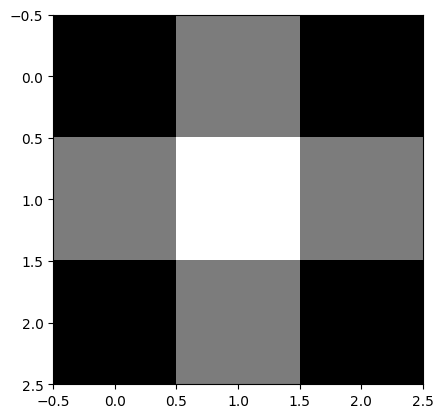

In [6]:
def gaussian_kernel(size, variance):
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-(x**2 + y**2)/float(2*variance))
    return g

variance = 10
g = gaussian_kernel(1, variance)
print(len(g))
plt.imshow(g, cmap='gray')
plt.show()

In [7]:
def create_gaussian(size, variance):
    gaussian_kernel_array = gaussian_kernel(size, variance)
    gaussian_kernel_array = gaussian_kernel_array * 255 / gaussian_kernel_array[int(len(gaussian_kernel_array) / 2)][int(len(gaussian_kernel_array) / 2)]
    gaussian_kernel_array = gaussian_kernel_array.astype(int)
    return gaussian_kernel_array

img = create_gaussian(3, 10)
print(img)

[[103 133 154 162 154 133 103]
 [133 170 198 208 198 170 133]
 [154 198 230 242 230 198 154]
 [162 208 242 255 242 208 162]
 [154 198 230 242 230 198 154]
 [133 170 198 208 198 170 133]
 [103 133 154 162 154 133 103]]


In [8]:
def create_ground_truth_images(path_input, path_output, size, variance, width, height):
    gaussian_kernel_array = create_gaussian(size, variance)
    for game_id in range(1,11):
        game = f'game{game_id}'
        clips = os.listdir(os.path.join(path_input, game))
        for clip in clips:
            print(f'game = {game}, clip = {clip}')

            path_out_game = os.path.join(path_output, game)
            if not os.path.exists(path_out_game):
                os.makedirs(path_out_game)
            
            path_out_clip = os.path.join(path_out_game, clip)
            if not os.path.exists(path_out_clip):
                os.makedirs(path_out_clip)

            path_labels = os.path.join(os.path.join(path_input, game, clip), 'Label.csv')
            labels = pd.read_csv(path_labels)
            for idx in range(labels.shape[0]):
                file_name, vis, x, y, _ = labels.loc[idx, :]
                heatmap = np.zeros((height, width, 3), dtype=np.uint8)
                if vis != 0:
                    x = int(x)
                    y = int(y)
                    for i in range(-size, size+1):
                        for j in range(-size, size+1):
                            if x+i < width and x+i >= 0 and y+j < height and y+j >= 0:
                                temp = gaussian_kernel_array[i+size][j+size]
                                if temp > 0:
                                    heatmap[y+j, x+i] = (temp, temp, temp)
                    
                cv2.imwrite(os.path.join(path_out_clip, file_name), heatmap)

#create_ground_truth_images('ai-tennis-analysis-tracknet/training/Dataset/tennis_ball/images', 'ai-tennis-analysis-tracknet/training/Dataset/tennis_ball/gts', 20, 10, 1280, 720)

In [9]:
def create_ground_truth_labels(path_input, path_output, train_rate=0.7):
    df = pd.DataFrame()
    for game_id in range(1, 11):
        game = f'game{game_id}'
        clips = os.listdir(os.path.join(path_input, game))
        for clip in clips:
            labels = pd.read_csv(os.path.join(path_input, game, clip, 'Label.csv'))
            labels['ground_truth_path'] = 'gts/' + game + '/' + clip + '/' + labels['file name']
            labels['path1'] = 'images/' + game + '/' + clip + '/' + labels['file name']
            labels_target = labels[2:]
            labels_target.loc[:, 'path2'] = list(labels['path1'][1:-1])
            labels_target.loc[:, 'path3'] = list(labels['path1'][:-2])
            df = pd.concat([df, labels_target])

    df = df.reset_index(drop=True)
    df = df[['path1', 'path2', 'path3', 'ground_truth_path', 'x-coordinate', 'y-coordinate', 'status', 'visibility']]
    df = df.sample(frac=1)
    num_train = int(df.shape[0] * train_rate)
    df_train = df[:num_train]
    df_val = df[num_train:]
    df_train.to_csv(os.path.join(path_output, 'labels_train.csv'), index=False)
    df_val.to_csv(os.path.join(path_output, 'labels_val.csv'), index=False)

#create_ground_truth_labels('ai-tennis-analysis-tracknet/training/Dataset/tennis_ball/images', 'ai-tennis-analysis-tracknet/training/Dataset/tennis_ball')

In [10]:
def combine_three_frames(frame1, frame2, frame3, width, height):
    # Resize and type converting for each frame
    img = cv2.resize(frame1, (width, height))
    # Input must be float type
    img = img.astype(np.float32)

    # Resize
    img1 = cv2.resize(frame2, (width, height))
    # Input must be float type
    img1 = img1.astype(np.float32)

    # Resize
    img2 = cv2.resize(frame3, (width, height))
    # Input must be float type
    img2 = img2.astype(np.float32)

    # combine three images to (width, height, rgb * 3)
    imgs = np.concatenate((img, img1, img2), axis=2)

    # since the ordering of TrackNet is channels first, we need to change the axis
    imgs = np.rollaxis(imgs, 2, 0)

    return np.array(imgs)

In [11]:
class BallDataset(Dataset):
    def __init__(self, mode, input_height=360, input_width=640):
        self.path_dataset = 'ai-tennis-analysis-tracknet/training/Dataset/tennis_ball'
        assert mode in ['train', 'val'], 'incorrect mode'
        self.data = pd.read_csv(os.path.join(self.path_dataset, f'labels_{mode}.csv'))
        print(f'mode = {mode}, samples = {self.data.shape[0]}') 

        self.width = input_width
        self.height = input_height


    
    def __len__(self):
        return self.data.shape[0]


    def __getitem__(self, idx):
        path, path_prev, path_preprev, path_gt, x, y, status, vis = self.data.loc[idx, :]

        path = os.path.join(self.path_dataset, path)
        path_prev = os.path.join(self.path_dataset, path_prev)
        path_preprev = os.path.join(self.path_dataset, path_preprev)
        path_gt = os.path.join(self.path_dataset, path_gt)

        if math.isnan(x):
            x = -1
            y = -1
        
        inputs = self.get_input(path, path_prev, path_preprev)
        outputs = self.get_output(path_gt)

        return inputs, outputs, x, y, vis

    def get_input(self, path, path_prev, path_preprev):
        img = cv2.imread(path)
        img = cv2.resize(img, (self.width, self.height))

        img_prev = cv2.imread(path_prev)
        img_prev = cv2.resize(img_prev, (self.width, self.height))

        img_preprev = cv2.imread(path_preprev)
        img_preprev = cv2.resize(img_preprev, (self.width, self.height))

        imgs = np.concatenate((img, img_prev, img_preprev), axis=2)
        imgs = imgs.astype(np.float32) / 255.0

        imgs = np.rollaxis(imgs, 2, 0)

        return imgs

    def get_output(self, path_gt):
        img = cv2.imread(path_gt)
        img = cv2.resize(img, (self.width, self.height))
        img = img[:, :, 0]
        img = np.reshape(img, (self.width * self.height))
        return img



In [12]:
train_dataset = BallDataset('train')
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

mode = train, samples = 13751


In [13]:
imgs, gt, x, y, vis = next(iter(train_loader))

tensor(395.5000, dtype=torch.float64) tensor(224.5000, dtype=torch.float64)


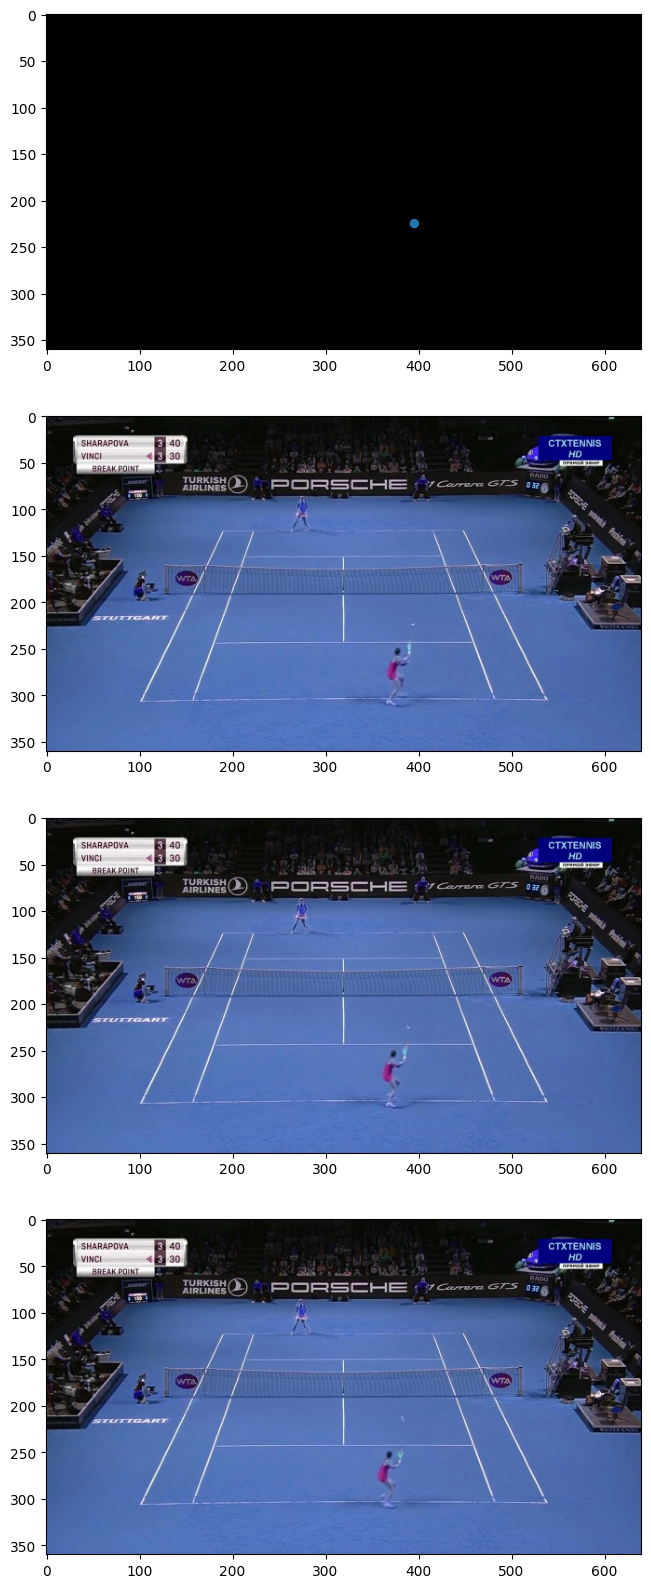

In [14]:
x = x[0]
y = y[0]

a = np.array(imgs[0])
b = a[:3]
c = a[3:6]
d = a[6:]
# a = np.rollaxis(a, 0, 3)
b = np.rollaxis(b, 0, 3)
c = np.rollaxis(c, 0, 3)
d = np.rollaxis(d, 0, 3)
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

e = np.array(gt)
e = np.reshape(e[0], (360, 640, 1))

ax = plt.subplot(411)
ax.imshow(e, cmap='gray')
print(x/2, y/2)
circle = Circle((x/2, y/2), 5)
ax.add_patch(circle)
ax = plt.subplot(412)
ax.imshow(b)
ax = plt.subplot(413)
ax.imshow(c)
ax = plt.subplot(414)
ax.imshow(d)

plt.show()

<img src='notebook_images/tracknet_architecture.png' style='width:720px'>

In [23]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True, bn=True):
        super().__init__()
        if bn:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=bias),
                nn.ReLU()
            )

    def forward(self, x):
        return self.block(x)
    
class BallTrackNet(nn.Module):
    def __init__(self, out_channels=256, bn=True):
        super().__init__()
        self.out_channels = out_channels

        # Encoder layers
        layer_1 = ConvBlock(in_channels=9, out_channels=64, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_2 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        layer_4 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_5 = ConvBlock(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_6 = nn.MaxPool2d(kernel_size=2, stride=2)
        layer_7 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_8 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_9 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_10 = nn.MaxPool2d(kernel_size=2, stride=2)
        layer_11 = ConvBlock(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_12 = ConvBlock(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_13 = ConvBlock(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=True, bn=bn)

        self.encoder = nn.Sequential(layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7, layer_8, layer_9, layer_10, layer_11, layer_12, layer_13)
        
        # Decoder layers
        layer_14 = nn.Upsample(scale_factor=2)
        layer_15 = ConvBlock(in_channels=512, out_channels=256, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_16 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_17 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_18 = nn.Upsample(scale_factor=2)
        layer_19 = ConvBlock(in_channels=256, out_channels=128, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_20 = ConvBlock(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_21 = nn.Upsample(scale_factor=2)
        layer_22 = ConvBlock(in_channels=128, out_channels=64, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_23 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=True, bn=bn)
        layer_24 = ConvBlock(in_channels=64, out_channels=self.out_channels, kernel_size=3, padding=1, bias=True, bn=bn)

        self.decoder = nn.Sequential(layer_14, layer_15, layer_16, layer_17, layer_18, layer_19, layer_20, layer_21, layer_22, layer_23, layer_24)

        self.softmax = nn.Softmax(dim=1)
        self._init_weights()
    

    def forward(self, x, testing=False):
        batch_size = x.size(0)
        features = self.encoder(x)
        scores_map = self.decoder(features)
        output = scores_map.reshape(batch_size, self.out_channels, -1)

        if testing:
            output = self.softmax(output)

        return output
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
    
    def inference(self, frames: torch.Tensor):
        self.eval()
        with torch.no_grad():
            if len(frames.shape) == 3:
                frames = frames.unsqueeze(0)
            if next(self.parameters()).is_cuda:
                frames.cuda()

            # Forward pass
            output = self(frames, True)
            output = output.argmax(dim=1).detach().cpu().numpy()
            if self.out_channels == 2:
                output *= 255
            x, y = self.get_center_ball(output)

        return x, y

    
    def get_center_ball(self, output):
    
        output = output.reshape((360, 640))

        # cv2 image must be np.uint8
        output = output.astype(np.uint8)

        # reshape image size
        heatmap = cv2.resize(output, (640, 360))

        # heatmap is converted into a binary image by threshold method
        ret, heatmap = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)

        if ret:
            plt.imshow(heatmap, cmap='gray')
            plt.show()

        # find the circle in image with 2 <= radius <=7
        circles = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=1, param1=50, param2=8, minRadius=2, maxRadius=7)
        
        

        # check if there is any tennis ball detected
        if circles is not None:
            if len(circles) == 1:
                x = int(circles[0][0][0])
                y = int(circles[0][0][1])
            
            return x, y
        return None, None



In [16]:
from scipy.spatial import distance

def train(model, train_loader, optimizer, device, epoch, max_iters=200):
    model.to(device)

    model.train()

    loss_fn = nn.CrossEntropyLoss()

    start_time = time.time()
    
    losses = []
    
    for iter_id, batch in enumerate(train_loader):
        X, y = batch[0].to(device), torch.tensor(batch[1], dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)


        loss.backward()
        optimizer.step()

        end_time = time.time()
        duration = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
        #print(f'epoch: {epoch}, loss: {loss:>7f}, iter: [{iter_id}/{max_iters}], time: {duration}')

        losses.append(loss.item())

        if iter_id > max_iters - 1:
            break

    return np.mean(losses)


def validate(model, val_loader, device, epoch, min_dist=5):
    losses = []
    tp = [0, 0, 0, 0]
    fp = [0, 0, 0, 0]
    tn = [0, 0, 0, 0]
    fn = [0, 0, 0, 0]
    loss_fn = nn.CrossEntropyLoss()
    model.eval()

    for iter_id, batch in enumerate(val_loader):
        with torch.no_grad():
            X, y = batch[0].to(device), torch.tensor(batch[1], dtype=torch.long).to(device)
            
            out = model(X)
            loss = loss_fn(out, y)
            losses.append(loss.item())

            # metrics
            output = out.argmax(dim=1).detach().cpu().numpy()
            for i in range(len(output)):
                x_pred, y_pred = postprocess(output[i])
                x_gt = batch[2][i]
                y_gt = batch[3][i]
                vis = batch[4][i]
                
                if x_pred:
                    if vis != 0:
                        dst = distance.euclidean((x_pred, y_pred), (x_gt, y_gt))

                        if dst < min_dist:
                            tp[vis] += 1
                        else:
                            fp[vis] +=1
                    else:
                        fp[vis] += 1

                if not x_pred:
                    if vis != 0:
                        fn[vis] += 1
                    else:
                        tn[vis] += 1
            
            #print(f'val | epoch = {epoch}, iter = [{iter_id}/{len(val_loader)}, loss = {np.mean(losses):7f}, tp = {sum(tp)}, tn = {sum(tn)}, fp = {sum(fp)}, fn = {sum(fn)}')
            
    eps = 1e-15
    precision = sum(tp) / (sum(tp) + sum(fp) + eps)
    vc1 = tp[1] + fp[1] + tn[1] + fn[1]
    vc2 = tp[2] + fp[2] + tn[2] + fn[2]
    vc3 = tp[3] + fp[3] + tn[3] + fn[3]
    recall = sum(tp) / (vc1 + vc2 + vc3 + eps)
    f1 = 2* precision * recall / (precision + recall + eps)

    print(f'precision = {precision}')
    print(f'recall = {recall}')
    print(f'f1 = {f1}')

    return np.mean(losses), precision, recall, f1
    

def postprocess(feature_map, scale=2):
    feature_map *= 255
    feature_map = feature_map.reshape((360, 640))
    feature_map = feature_map.astype(np.uint8)
    ret, heatmap = cv2.threshold(feature_map, 127, 255, cv2.THRESH_BINARY)
    circles = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=1, param1=50, param2=2, minRadius=2, maxRadius=7)
    x, y = None, None

    if circles is not None:
        if len(circles) == 1:
            x = circles[0][0][0]*scale
            y = circles[0][0][1]*scale
    
    return x, y
            

In [17]:
class BallDetector:
    def __init__(self, device, save_state=None, out_channels=2):
        self.device = device

        # Load TrackNet model weights
        self.detector = BallTrackNet(out_channels=out_channels)
        saved_state_dict = torch.load(save_state, map_location=torch.device('cpu'))
        self.detector.load_state_dict(saved_state_dict['state_dict'])
        self.detector.eval().to(self.device)

        self.current_frame = None
        self.last_frame = None
        self.before_last_frame = None

        self.video_width = None
        self.video_height = None
        self.model_input_width = 640
        self.model_input_height = 360

        self.threshold_dist = 100
        self.xy_coordinates = np.array([[None, None], [None, None]])

        self.bounces_indices = []

    def detect_ball(self, frame):
        # save frame dimensions
        if self.video_width is None:
            self.video_width = frame.shape[1]
            self.video_height = frame.shape[0]
        
        self.last_frame = self.before_last_frame
        self.before_last_frame = self.current_frame
        self.current_frame = frame.copy()

        # detect only if 3 frames were given
        if self.last_frame is not None:
            # combine the frames into 1 input tensor
            frames = combine_three_frames(self.current_frame, self.before_last_frame, self.last_frame, self.model_input_width, self.model_input_height)

            frames = (torch.from_numpy(frames) / 255).to(self.device)

            x, y = self.detector.inference(frames)
            if x is not None:
                # rescale the indices to fit dimensions
                x = int(x * (self.video_width / self.model_input_width))
                y = int(y * (self.video_height / self.model_input_height))

            # check the distance from previous location and remove outliers
            if self.xy_coordinates[-1][0] is not None:
                if np.linalg.norm(np.array([x, y]) - self.xy_coordinates[-1]) > self.threshold_dist:
                    x, y = None, None
        
            self.xy_coordinates = np.append(self.xy_coordinates, np.array([[x, y]]), axis=0)



In [18]:
val_dataset = BallDataset('val')
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

mode = val, samples = 5894


In [19]:
import shutil
def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    torch.save(state, checkpoint_dir)
    if is_best:
        shutil.copyfile(checkpoint_dir, best_model_dir)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [20]:
from tensorboardX import SummaryWriter
from torchinfo import summary

exp_id = 1
exps_path = f'ai-tennis-analysis-tracknet/training/exps/{exp_id}'

tb_path = os.path.join(exps_path, 'plots')
if not os.path.exists(tb_path):
    os.makedirs(tb_path)
log_writer = SummaryWriter(tb_path)
model_last_path = os.path.join(exps_path, 'model_last.pt')
model_best_path = os.path.join(exps_path, 'model_best.pt')



def train_tracknet():
    model = BallTrackNet()
    epochs = 500
    steps_per_epoch = 200
    lr = 1.0
    optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

    val_interval = 50

    val_best_metric = 0


    start_time = time.time()

    model, optimizer, start_epoch = load_ckp(model_last_path, model, optimizer)

    print(summary(model, input_size=(2, 9, 360, 640)))

    for epoch in range(start_epoch, epochs + 1):
        print(epoch)
        train_start_time = time.time()
        train_loss = train(model, train_loader, optimizer, device, epoch, max_iters=steps_per_epoch)
        train_end_time = time.time()
        train_duration = time.strftime('%H:%M:%S', time.gmtime(train_end_time - train_start_time))
        
        print(f'Train | Epoch: {epoch} / {epochs} | Loss: {train_loss} | Time: {train_duration}')
        log_writer.add_scalar('Train/training_loss', train_loss, epoch)
        log_writer.add_scalar('Train/lr', optimizer.param_groups[0]['lr'], epoch)

        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_ckp(checkpoint, False, model_last_path, model_best_path)

        if (epoch > 0) & (epoch % val_interval == 0):
            val_start_time = time.time()
            val_loss, precision, recall, f1 = validate(model, val_loader, device, epoch)
            val_end_time = time.time()
            val_duration = time.strftime('%H:%M:%S', time.gmtime(val_end_time - val_start_time))
            
            print(f'Val | Epoch: {epoch} / {epochs} | Loss: {val_loss} | Time: {val_duration}')
            log_writer.add_scalar('Val/loss', val_loss, epoch)
            log_writer.add_scalar('Val/precision', precision, epoch)
            log_writer.add_scalar('Val/recall', recall, epoch)
            log_writer.add_scalar('Val/f1', f1, epoch)
            
            if f1 > val_best_metric:
                checkpoint = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
                val_best_metric = f1
                save_ckp(checkpoint, True, model_last_path, model_best_path)

    end_time = time.time()
    duration = time.strftime('%H:%M:%S', time.gmtime(end_time - start_time))

    print(f'Summary | Epochs: {epochs} | Time: {duration} | Device: {device}')

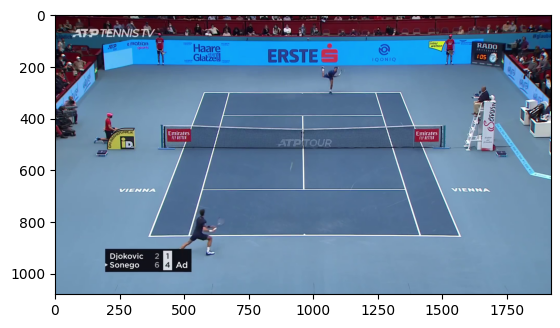

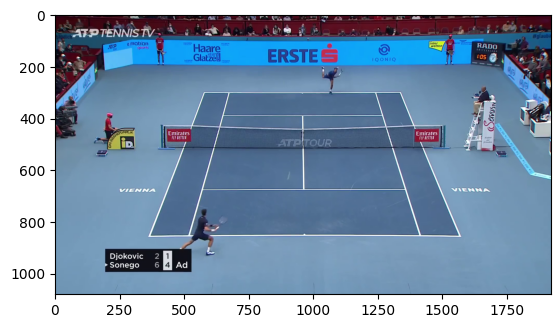

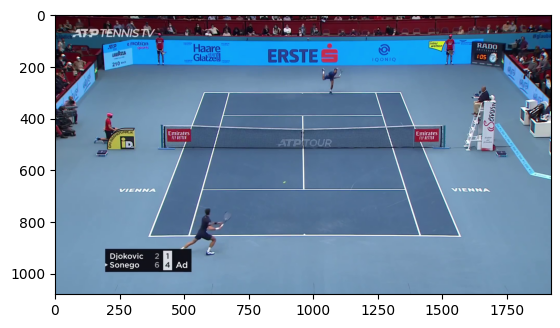

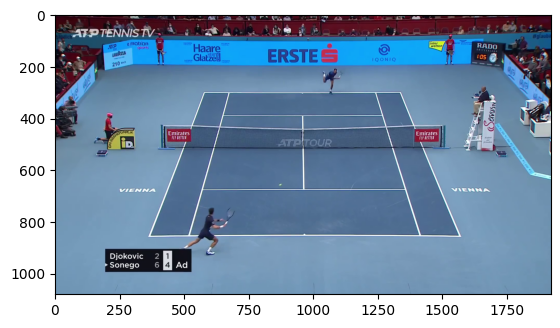

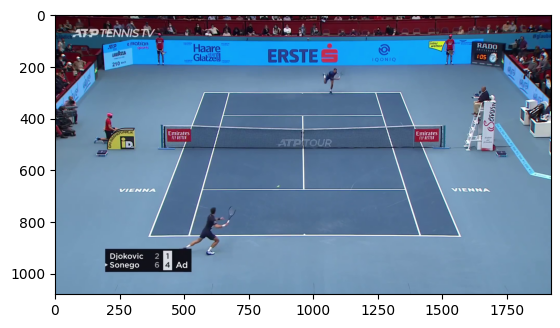

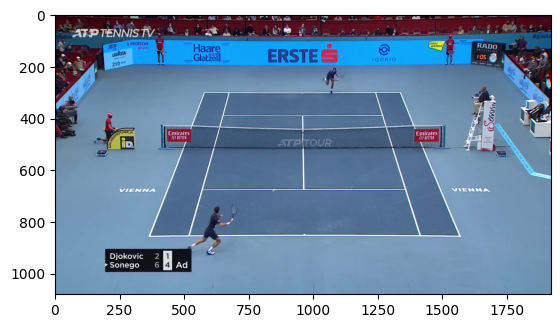

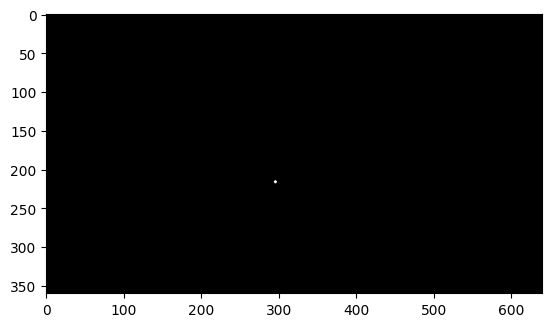

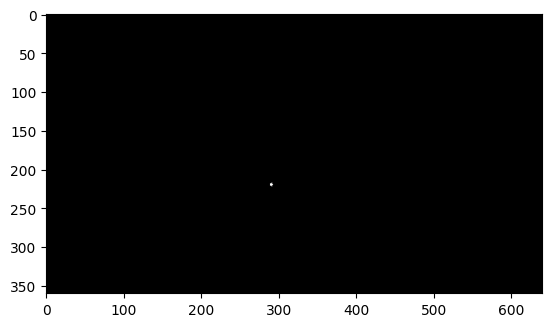

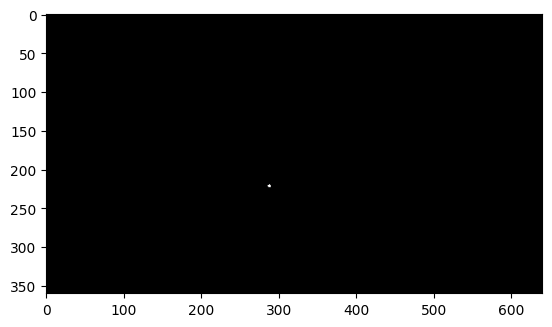

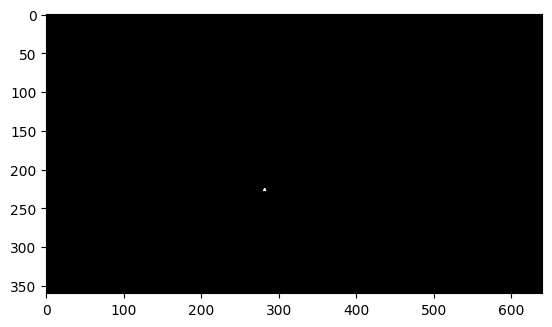

[[None None]
 [None None]
 [None None]
 [None None]
 [None None]
 [None None]]


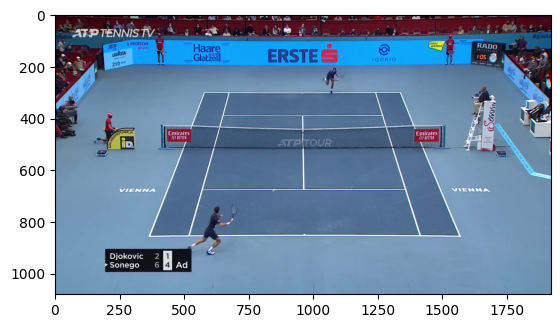

In [24]:
import sys
sys.path.append('ai-tennis-analysis-tracknet/')
from utils.video_utils import read_video, save_video

# read video
input_video_path = 'ai-tennis-analysis-tracknet/input_videos/input_video_a.mp4'

video_frames = read_video(input_video_path)

# detect ball
ball = BallDetector(device, model_last_path, 256)


# draw output
output_video_frames = video_frames[:6]

for frame in output_video_frames:
    frame = np.array(frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.imshow(frame)
    plt.show()


for frame in output_video_frames:
    ball.detect_ball(frame)

print(ball.xy_coordinates)

frame = cv2.cvtColor(output_video_frames[-1], cv2.COLOR_BGR2RGB)
ax = plt.subplot(111)
ax.imshow(frame)

x, y = ball.xy_coordinates[-1]

if x is not None:
    circle = Circle((x, y), 50)
    ax.add_patch(circle)
    plt.show()

## draw frame number on top left corner
for i, frame in enumerate(output_video_frames):
    cv2.putText(frame, f'Frame: {i}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

save_video(output_video_frames, 'ai-tennis-analysis-tracknet/training/output/output_video.avi')